<span style="font-family: Arial; font-weight:bold;font-size:2em;color:#00b3e5;"> Code Spaze task 1c Sentiment Analysis
    
<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;"> Submitted by
    
<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;"> Shameer.Sutar


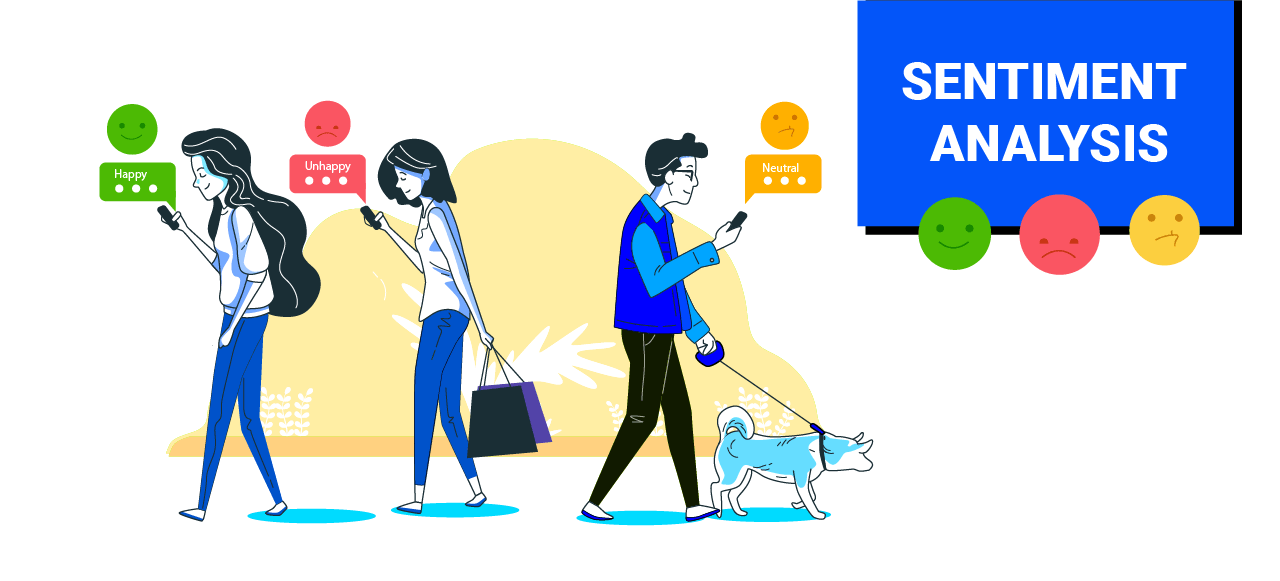

In [60]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('omw-1.4')
import string
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
# Download NLTK data (stopwords, punkt tokenizer, wordnet)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Loading and Exploration

In [57]:
# Load the CSV file
file_path = 'D:/CodeSpaze/Sentiment Analysis of Product Reviews/amazon.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to get a preview
df

,Text,label
0,This is the best apps acording to a bunch of ...,1
1,This is a pretty good version of the game for ...,1
2,this is a really . there are a bunch of levels...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1
...,...,...
19991,this app is fricken stupid.it froze on the kin...,0
19992,Please add me!!!!! I need neighbors! Ginger101...,1
19993,love it! this game. is awesome. wish it had m...,1
19994,I love love love this app on my side of fashio...,1


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19996 entries, 0 to 19995
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    19996 non-null  object
 1   label   19996 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [30]:
# Display a sample of reviews
print("Sample Reviews:\n")
for i in range(5):
    print(f"Review {i+1}:\n{df['Text'].iloc[i]}\n")


Sample Reviews:

Review 1:
This is  the best apps acording to a bunch of people and I agree it has bombs eggs pigs TNT king pigs and realustic stuff

Review 2:
This is a pretty good version of the game for being free. There are LOTS of different levels to play. My kids enjoy it a lot too.

Review 3:
this is a really . there are a bunch of levels and you can find golden eggs. super fun.

Review 4:
This is a silly game and can be frustrating, but lots of fun and definitely recommend just as a fun time.

Review 5:
This is a terrific game on any pad. Hrs of fun.  My grandkids love it. Great entertainment when waiting in long lines



>**The dataset contains two columns: 'Text' (the review content) and 'label' (the sentiment, where 1 is positive and 0 is negative).**

>**There are 19,996 reviews in total, which is a good size for a sentiment analysis task.**

>**The data appears to be clean, with no obvious missing values or formatting issues in the sample shown.**

## Label Distribution Visualization

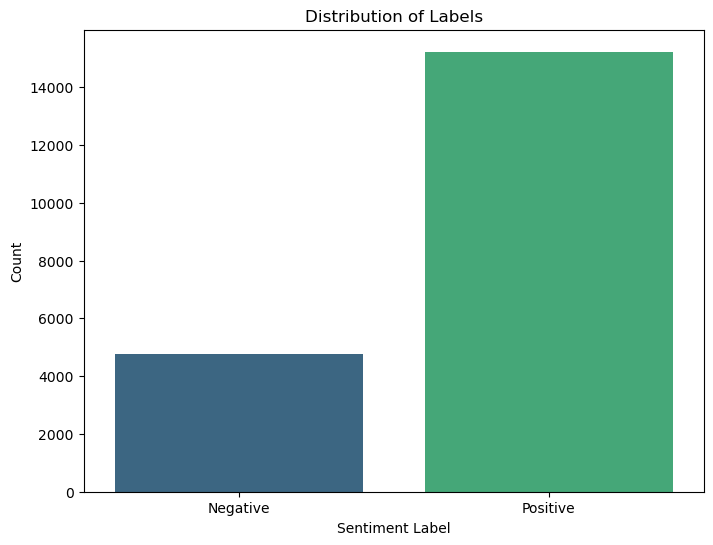

In [27]:
# Plot distribution of labels
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label', palette='viridis')
plt.title('Distribution of Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()


>**There's a clear class imbalance, with positive reviews (label 1) significantly outnumbering negative reviews (label 0).**

>**This imbalance could potentially bias the model towards predicting positive sentiment more often.**

>**Consider using techniques like oversampling, undersampling, or adjusting class weights in your models to address this imbalance.**

## Review Length Analysis

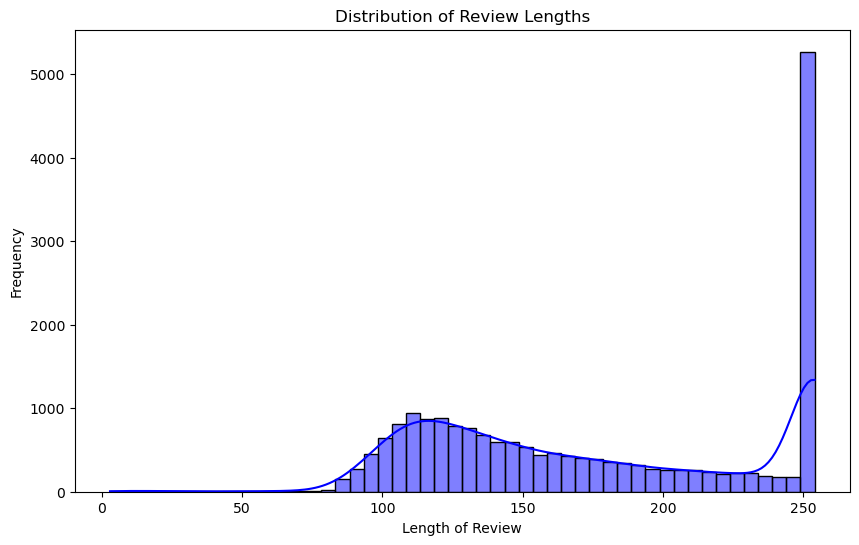

In [28]:
# Add a column for the length of each review
df['text_length'] = df['Text'].apply(len)

# Plot distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.show()


>**There's a wide range of review lengths, with most reviews being relatively short but some extending to much greater lengths.**

>**The distribution appears to be right-skewed, with a long tail of very long reviews.**

>**You might consider whether extremely short or long reviews need special handling in your preprocessing or modeling steps.**

## Word Cloud Generation

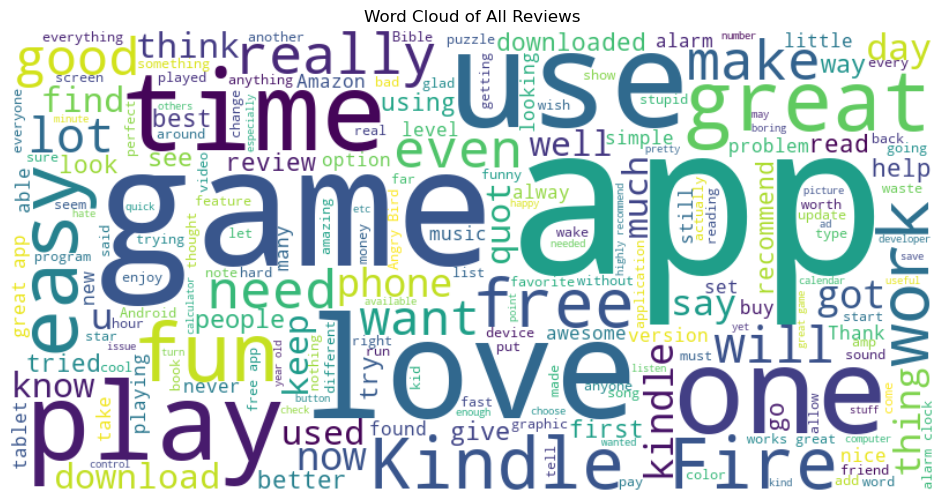

In [29]:
# Combine all reviews into a single string
all_reviews = ' '.join(df['Text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Plot word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Reviews')
plt.show()


>**This provides a quick visual overview of the most frequent words in the dataset.**

>**Words like "game", "app", "love", and "fun" appear to be prominent, suggesting many reviews are about games or apps and have positive sentiment.**

## Text Length Distribution by Sentiment

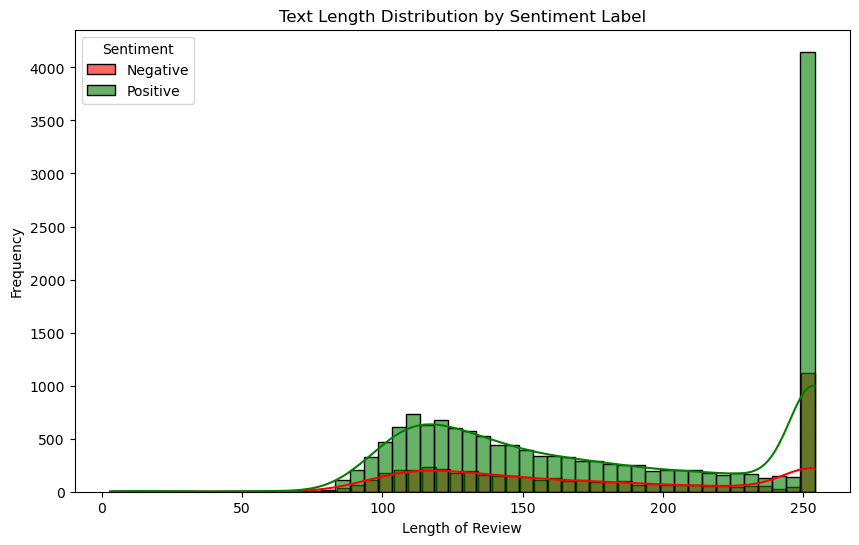

In [37]:
# Plot text length distribution by label
plt.figure(figsize=(10, 6))

# Create histograms for each label
sns.histplot(data=df[df['label'] == 0], x='text_length', bins=50, kde=True, color='red', label='Negative', alpha=0.6)
sns.histplot(data=df[df['label'] == 1], x='text_length', bins=50, kde=True, color='green', label='Positive', alpha=0.6)

# Add title and labels
plt.title('Text Length Distribution by Sentiment Label')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')

# Add legend
plt.legend(title='Sentiment')

plt.show()

>**Both positive and negative reviews show a similar right-skewed distribution of lengths.**

>**There doesn't seem to be a stark difference in length between positive and negative reviews, suggesting length alone may not be a strong predictor of sentiment.**

## Text Preprocessing

In [39]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)
# Apply preprocessing
df['processed_text'] = df['Text'].apply(preprocess_text)

# Display the first few rows of the dataframe to verify
df

,Text,label,processed_text,text_length
0,This is the best apps acording to a bunch of ...,1,best apps acording bunch people agree bomb egg...,121
1,This is a pretty good version of the game for ...,1,pretty good version game free lot different le...,129
2,this is a really . there are a bunch of levels...,1,really bunch level find golden egg super fun,87
3,"This is a silly game and can be frustrating, b...",1,silly game frustrating lot fun definitely reco...,105
4,This is a terrific game on any pad. Hrs of fun...,1,terrific game pad hr fun grandkids love great ...,117
...,...,...,...,...
19991,this app is fricken stupid.it froze on the kin...,0,app fricken stupidit froze kindle wont allow p...,254
19992,Please add me!!!!! I need neighbors! Ginger101...,1,please add need neighbor ginger1016 thanks bun...,185
19993,love it! this game. is awesome. wish it had m...,1,love game awesome wish free stuff house didnt ...,105
19994,I love love love this app on my side of fashio...,1,love love love app side fashion story fight wo...,254


>**The above observation shows clean andthe processed text,text lenth after removing stop word then removing puctuations and then lemmatizing.**

>**This is a comprehensive preprocessing pipeline that should help standardize the text data.**

## Word Clouds for Positive and Negative Reviews

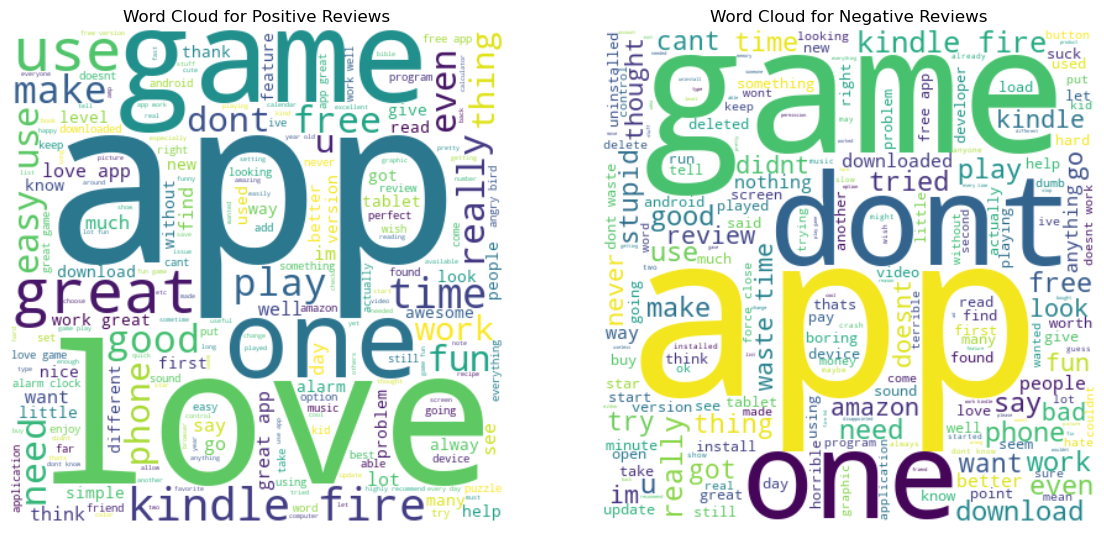

In [40]:
# Create word clouds for positive and negative reviews
positive_reviews = ' '.join(df[df['label'] == 1]['processed_text'])
negative_reviews = ' '.join(df[df['label'] == 0]['processed_text'])

# Generate and plot word clouds
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Positive reviews
wordcloud_pos = WordCloud(width=400, height=400, background_color='white').generate(positive_reviews)
ax[0].imshow(wordcloud_pos, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Word Cloud for Positive Reviews')

# Negative reviews
wordcloud_neg = WordCloud(width=400, height=400, background_color='white').generate(negative_reviews)
ax[1].imshow(wordcloud_neg, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Word Cloud for Negative Reviews')

plt.show()


>**This allows for a visual comparison of words associated with each sentiment.**

>**Words like "love", "great", and "fun" seem prominent in positive reviews.**

>**Words like "waste", "bad", and "boring" appear more in negative reviews.**

>**This visualization can help in feature selection or in understanding what words are most indicative of each sentiment.**

## Most Common Words Analysis

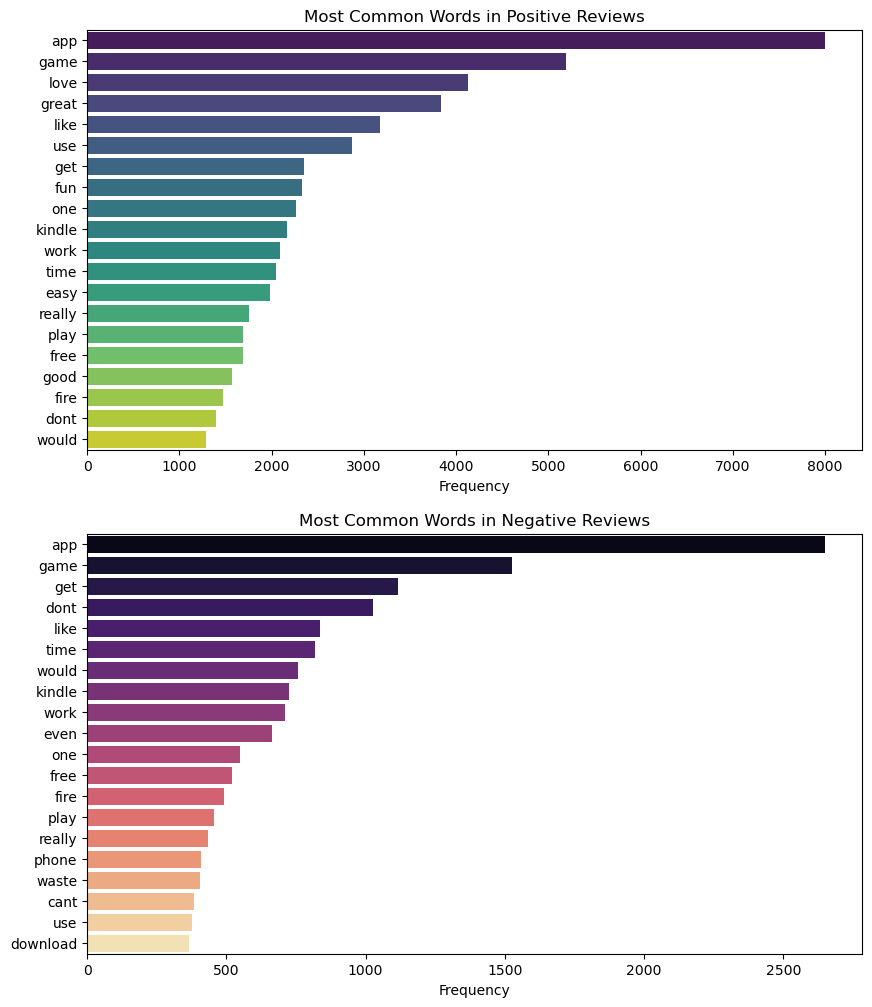

In [41]:
def get_most_common_words(text_series, num_words=20):
    all_words = ' '.join(text_series)
    word_counts = Counter(all_words.split())
    return dict(word_counts.most_common(num_words))

# Get most common words
common_words_pos = get_most_common_words(df[df['label'] == 1]['processed_text'])
common_words_neg = get_most_common_words(df[df['label'] == 0]['processed_text'])

# Plot common words
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Positive reviews
sns.barplot(x=list(common_words_pos.values()), y=list(common_words_pos.keys()), ax=ax[0], palette='viridis')
ax[0].set_title('Most Common Words in Positive Reviews')
ax[0].set_xlabel('Frequency')

# Negative reviews
sns.barplot(x=list(common_words_neg.values()), y=list(common_words_neg.keys()), ax=ax[1], palette='magma')
ax[1].set_title('Most Common Words in Negative Reviews')
ax[1].set_xlabel('Frequency')

plt.show()


>**This provides a more quantitative look at word frequencies compared to the word clouds.**
    
>**Some words (like "game" or "app") appear frequently in both positive and negative reviews, suggesting they may not be strong sentiment indicators.**

>**Words unique to each sentiment category could be particularly useful for classification.**

## TF-IDF Vectorization

In [42]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_text'])
y = df['label']


>**TF-IDF is a solid choice for text classification tasks, as it accounts for both word frequency and importance.**

>**Limiting to 5000 features helps manage dimensionality while likely still capturing the most important words.**

## Model Training and Evaluation

In [43]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [44]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Results for {name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")


Results for Logistic Regression:
Accuracy: 0.8878
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.65      0.74       978
           1       0.89      0.96      0.93      3022

    accuracy                           0.89      4000
   macro avg       0.88      0.81      0.83      4000
weighted avg       0.89      0.89      0.88      4000


Results for Random Forest:
Accuracy: 0.8690
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.57      0.68       978
           1       0.87      0.97      0.92      3022

    accuracy                           0.87      4000
   macro avg       0.86      0.77      0.80      4000
weighted avg       0.87      0.87      0.86      4000


Results for SVM:
Accuracy: 0.8962
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.68      0.76       978
           1       0.90      0.97     

>**trained and evaluated three models: Logistic Regression, Random Forest, and SVM.**

>**Insights:**

>**All models performed reasonably well, with accuracies around 87-90%.**

>**SVM slightly outperformed the other models, which is common for text classification tasks.**

>**All models struggled more with correctly identifying negative reviews (lower recall for class 0), likely due to the class imbalance.**

## Confusion Martix

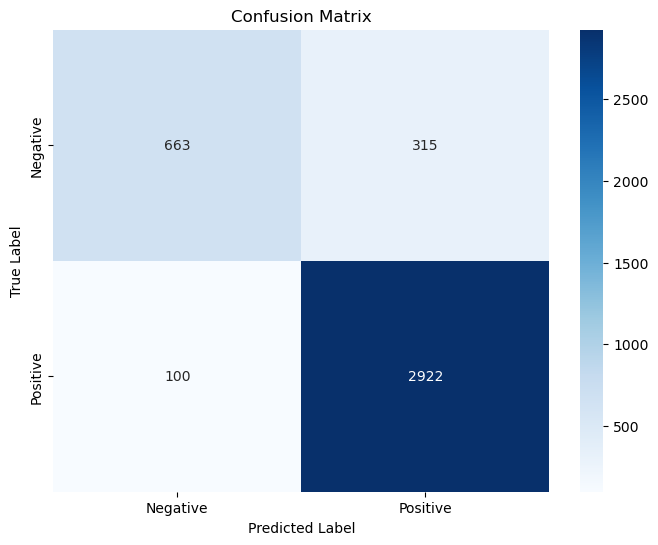

In [45]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Insights:

True Negatives (top-left): 663

The model correctly identified 663 negative reviews.
This represents about 67.8% of the actual negative reviews in the test set.


False Positives (top-right): 315

The model incorrectly classified 315 negative reviews as positive.
This is a significant number of misclassifications for negative reviews.


False Negatives (bottom-left): 100

The model misclassified 100 positive reviews as negative.
This is relatively low compared to the total number of positive reviews.


True Positives (bottom-right): 2922

The model correctly identified 2922 positive reviews.
This represents about 96.7% of the actual positive reviews in the test set.


Overall Performance:

The model performs well overall, with the majority of predictions falling in the correct categories (diagonal cells).
There's a clear imbalance in the dataset, with many more positive reviews than negative ones.


Class-specific Performance:

Negative class (0): The model has moderate recall (663 / (663 + 315) ≈ 67.8%) but lower precision for negative reviews.
Positive class (1): The model has both high precision and high recall for positive reviews.


Misclassifications:

The model is more likely to misclassify negative reviews as positive (315 cases) than vice versa (100 cases).
This suggests that the model has a bias towards predicting positive sentiment.


Impact of Class Imbalance:

The class imbalance is reflected in the model's performance, with much better performance on the majority class (positive reviews).
The model struggles more with correctly identifying negative reviews, likely due to their underrepresentation in the training data.


Areas for Improvement:

Focus on reducing false positives (315), which is the largest source of error.
Consider techniques to address class imbalance to improve performance on negative reviews.

## Cross-Validation

In [47]:
# Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

# Initialize cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_results[name] = scores
    print(f'{name} - Mean Accuracy: {scores.mean():.4f} ± {scores.std():.4f}')


Logistic Regression - Mean Accuracy: 0.8860 ± 0.0047
Random Forest - Mean Accuracy: 0.8710 ± 0.0064
SVM - Mean Accuracy: 0.8917 ± 0.0042


>**This step helps ensure the model performance is consistent and not just due to a lucky split of the data.**

>**SVM consistently performed the best, with the highest mean accuracy and lowest standard deviation.**

In [48]:
# Train the best model (assuming SVM is the best based on cross-validation)
best_model = SVC()
best_model.fit(X_train, y_train)

# Predict on test data
y_pred = best_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

# Print accuracy and classification report
print(f'Test Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))


Test Accuracy: 0.8962
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.68      0.76       978
           1       0.90      0.97      0.93      3022

    accuracy                           0.90      4000
   macro avg       0.89      0.82      0.85      4000
weighted avg       0.89      0.90      0.89      4000



## Final Model Evaluation

In [51]:
# Create a DataFrame to display predictions alongside true labels
results_df = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': y_pred
})

# Display a few rows of the DataFrame
print(results_df.head())

# Optionally, you can also save the results to a CSV file if needed
results_df.to_csv('predictions.csv', index=False)

       True Label  Predicted Label
18883           0                0
2140            1                1
6110            0                0
14526           1                1
10865           1                1


>**The final model achieved 89.62% accuracy on the test set.**

>**The model performs better on positive reviews (0.97 recall) than negative reviews (0.68 recall), likely due to the class imbalance.**

## Conclusion:

The sentiment analysis model demonstrates strong overall performance, achieving an accuracy of 89.62% on the test set. However, the confusion matrix reveals important nuances in its predictive capabilities:

Positive Sentiment Detection: The model excels at identifying positive reviews, correctly classifying 2922 out of 3022 positive instances (96.7% recall). This high accuracy for positive sentiment is a significant strength of the model.
Negative Sentiment Detection: The model struggles more with negative reviews, correctly identifying 663 out of 978 negative instances (67.8% recall). This lower performance on negative sentiment is the primary area for improvement.
Bias Towards Positive Predictions: There's a noticeable tendency for the model to classify reviews as positive, evidenced by the higher number of false positives (315) compared to false negatives (100). This bias likely stems from the class imbalance in the dataset.
Impact of Class Imbalance: The disparity in performance between positive and negative classes reflects the imbalanced nature of the dataset, with positive reviews significantly outnumbering negative ones.
Precision vs Recall Trade-off: The model achieves high precision for positive reviews but at the cost of lower precision for negative reviews. This trade-off is common in imbalanced classification problems.

To enhance the model's performance, future work should focus on:

Addressing class imbalance through techniques like oversampling, undersampling, or synthetic data generation.
Fine-tuning the model to improve its ability to detect negative sentiment without compromising its strong performance on positive reviews.
Exploring more advanced feature engineering or deep learning approaches that might capture subtle negative sentiments more effectively.
Considering domain-specific insights to better understand and classify challenging negative reviews.

In conclusion, while the model performs well overall, there's room for improvement in handling negative sentiment. Addressing these challenges could lead to a more balanced and robust sentiment analysis tool, capable of providing more accurate insights across both positive and negative customer feedback.

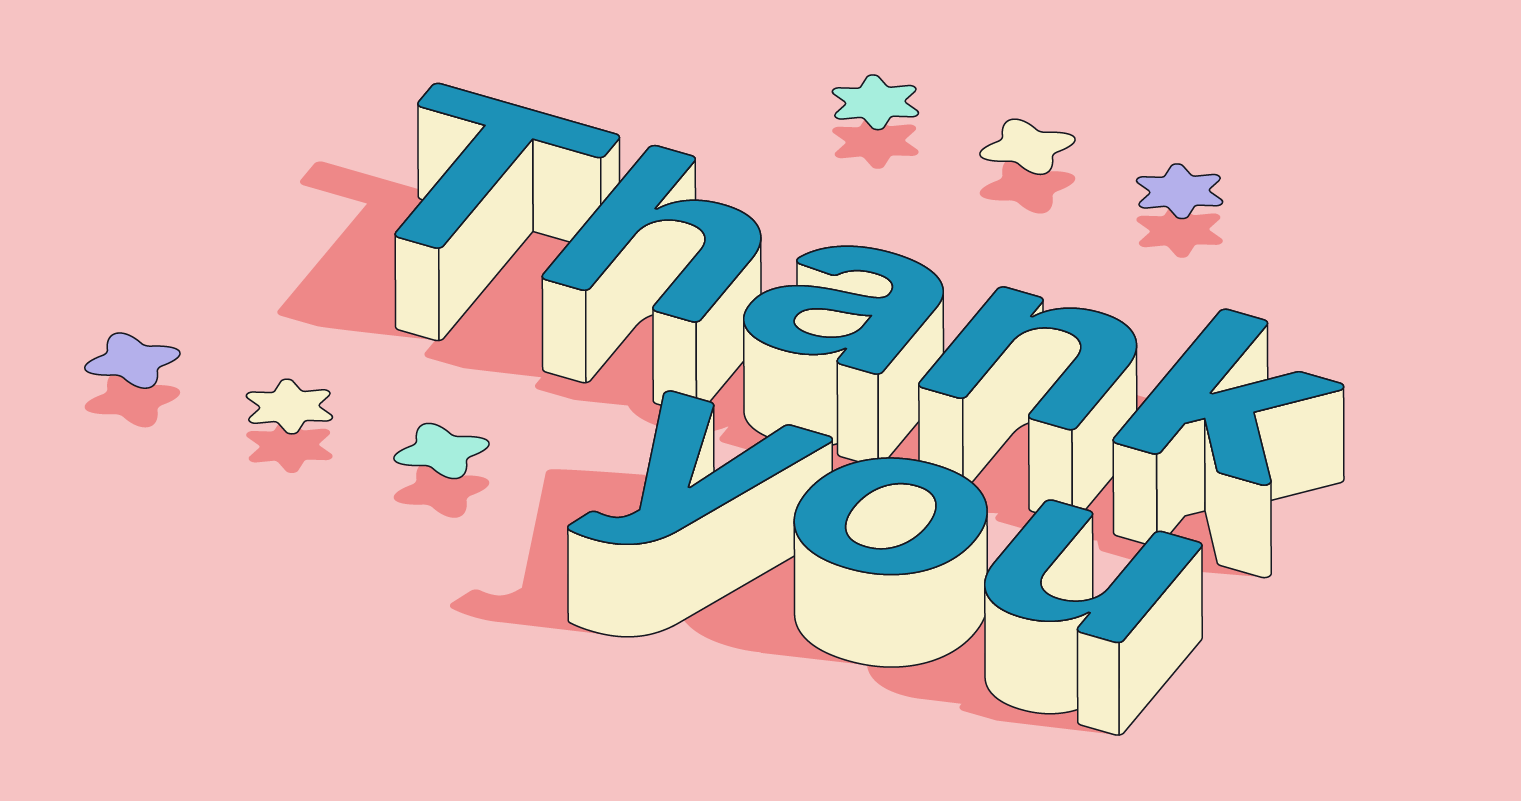